In [1]:
from pennylane import numpy as np
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import pennylane as qml
import embedding

In [2]:
dev = qml.device('default.qubit', wires=12)

In [3]:

PATH_Model2 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/12 qubits/PCA-NQE500.pt'
PATH_Model3 = '/home/tak/Github/QEmbedding/Other Experiments/Scalability/12 qubits/NQE500.pt'

In [4]:
class x_transform2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(12, 36),
            nn.ReLU(),
            nn.Linear(36, 36),
            nn.ReLU(),
            nn.Linear(36, 24)
        )
        
    def forward(self, x):
        x = self.linear_relu_stack2(x)
        return x.detach().numpy()


class x_transform3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Layer2: 14 * 14 -> 7 * 7
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 1, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected Layers 7 * 7 -> 7
        self.fc = torch.nn.Linear(7 * 7, 24, bias=True)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 7 * 7)
        x = self.fc(x)
        return x.detach().numpy()

model2 = x_transform2()
model3 = x_transform3()

model2.load_state_dict(torch.load(PATH_Model2))
model3.load_state_dict(torch.load(PATH_Model3))

<All keys matched successfully>

In [5]:
@qml.qnode(dev)
def overlap_circuit1(x1,x2):
    embedding.Twelve_QuantumEmbedding1(x1)
    embedding.Twelve_QuantumEmbedding1_inverse(x2)
    return qml.probs(wires=range(12))

@qml.qnode(dev)
def overlap_circuit2(x1,x2):
    embedding.Twelve_QuantumEmbedding2(x1)
    embedding.Twelve_QuantumEmbedding2_inverse(x2)
    return qml.probs(wires=range(12))

def kernel(x1, x2, NQE):
    if NQE == False:
        kernel = overlap_circuit1(x1,x2)
    
    
    elif NQE == 'PCA-NQE':
        x1 = model2(torch.tensor(x1))
        x2 = model2(torch.tensor(x2))
        kernel = overlap_circuit2(x1, x2)

    elif NQE == 'NQE':
        x1 = model3(torch.tensor(x1))[0]
        x2 = model3(torch.tensor(x2))[0]
        kernel = overlap_circuit2(x1,x2)
    
    return kernel

  

In [6]:
def get_error_bound(weights, Kernel):
    error_list = []
    for weight in weights:
        Kernel_MP = np.linalg.pinv(Kernel + weight * np.eye(N), hermitian = True)
        error_list.append(np.sqrt(Y_train @ Kernel_MP @ Kernel @ Kernel_MP @ Y_train.T / N))
        
    error_list = np.array(error_list)

    return error_list

QKM without NQE

In [31]:
feature_reduction = 'PCA12'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel0 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], False)
        Kernel0[i][j] = x[0]
        Kernel0[j][i] = x[0]

In [32]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel0)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list {k}\n")
f.write(str(error_list))
f.close()

QKM with PCA-NQE

In [33]:
feature_reduction = 'PCA12'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel2 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "PCA-NQE")
        Kernel2[i][j] = x[0]
        Kernel2[j][i] = x[0]

In [34]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel2)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (PCA-NQE) {k}\n")
f.write(str(error_list))
f.close()

QKM with NQE

In [35]:
classes = [0,1]
feature_reduction = False
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)
X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
X_train, X_test = X_train.permute(0,3,1,2).detach().numpy(), X_test.permute(0,3,1,2).detach().numpy()
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]
Y_train = np.array(Y_train)

k = 3
N = 1000
X_train = X_train[k * N: (k + 1) * N]
Y_train = Y_train[k * N: (k + 1) * N]

Kernel3 = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        x = kernel(X_train[i], X_train[j], "NQE")
        Kernel3[i][j] = x[0]
        Kernel3[j][i] = x[0]

In [36]:
weights = np.arange(0.1 , 1, 0.1)
error_list = get_error_bound(weights, Kernel3)
f = open("generalization.txt", 'a')
f.write("\n")
f.write(f"Generalization Error bounds list (NQE) {k}\n")
f.write(str(error_list))
f.close()

In [38]:
weights = np.arange(0.1, 1, 0.1)
error_list0 = [0.81438268, 0.75384256, 0.70224157, 0.65766229, 0.61872681, 0.58440446,
 0.5539053 , 0.52661242, 0.50203639, 0.82308318, 0.76175239, 0.70946149, 0.66427996, 0.62481325, 0.59001724,
 0.55909173, 0.53141195, 0.50648242, 0.82777863, 0.76571437, 0.71281497, 0.66712291, 0.62722387, 0.59205912,
 0.56081721, 0.53286449, 0.50769837, 0.82526292, 0.76362019, 0.71106686, 0.66567013, 0.62602619, 0.59108289,
 0.56003374, 0.53224911, 0.50722975, 0.83058901, 0.76853704, 0.71562414, 0.66990357, 0.62996337, 0.59474626,
 0.56344225, 0.53541926, 0.51017623]
error_list2 = [0.20066348, 0.14196904, 0.11734274, 0.10326964, 0.09400114, 0.0873725,
 0.08236871, 0.07844442, 0.07527783, 0.23173736, 0.15835732, 0.12783705, 0.11057399, 0.09932638, 0.09136872,
 0.08542419, 0.08080809, 0.07711764, 0.22972942, 0.15772882, 0.12780735, 0.11106105, 0.10024771, 0.09263344,
 0.08694913, 0.08252361, 0.07896795, 0.23438756, 0.1624553 , 0.13162915, 0.11403054, 0.10252   , 0.09435564,
 0.08824141, 0.08347996, 0.07966088, 0.21457365, 0.14814565, 0.12009894, 0.10412278, 0.0936865 , 0.08630212,
 0.08079364, 0.0765262 , 0.07312454]
error_list3 = [0.17119253, 0.1280326 , 0.10849354, 0.09687357, 0.08905544, 0.0834051,
 0.07912397, 0.07576858, 0.07307028, 0.16880812, 0.12947793, 0.11166693, 0.10091907, 0.09355217, 0.0881216,
 0.08392403, 0.08056878, 0.07781852, 0.15888386, 0.11854168, 0.10097335, 0.0908696 , 0.08423344, 0.07951382,
 0.07597329, 0.07321337, 0.07099861, 0.1717659 , 0.13070254, 0.11227934, 0.10129875, 0.09384089, 0.08837772,
 0.08417343, 0.08082359, 0.0780846 , 0.17552808, 0.12892485, 0.10905881, 0.09757438, 0.08994428, 0.08445076,
 0.08028265, 0.07700108, 0.07434536]

error_list0, error_list2, error_list3 = np.array(error_list0), np.array(error_list2), np.array(error_list3)
error_list0 = error_list0.reshape(5,9)
error_list2 = error_list2.reshape(5,9)
error_list3 = error_list3.reshape(5,9)

error_list0_mean, error_list0_std = error_list0.mean(axis=0), error_list0.std(axis=0)
error_list2_mean, error_list2_std = error_list2.mean(axis=0), error_list2.std(axis=0)
error_list3_mean, error_list3_std = error_list3.mean(axis=0), error_list3.std(axis=0)

/tmp/ipykernel_12739/1315228976.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
/tmp/ipykernel_12739/1315228976.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
/tmp/ipykernel_12739/1315228976.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA s

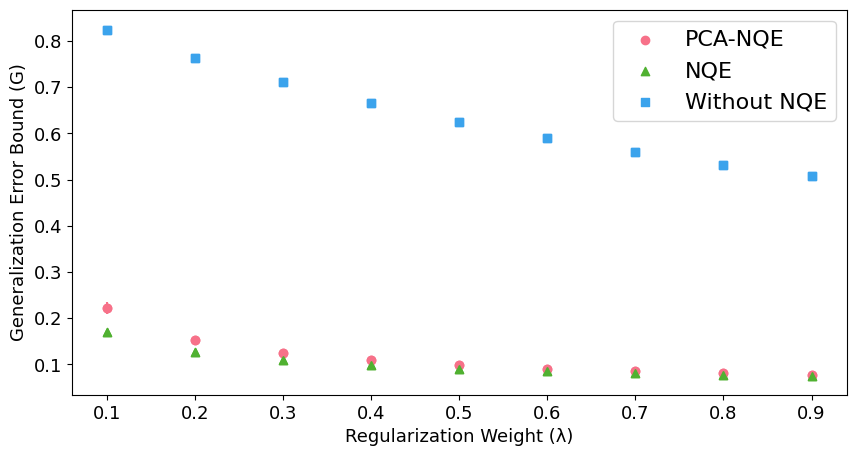

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):
    
    ax.scatter(weights, error_list2_mean, label="PCA-NQE", marker="o", c=clrs[0])
    ax.scatter(weights, error_list3_mean, label="NQE", marker="^", c=clrs[1])
    ax.scatter(weights, error_list0_mean, label="Without NQE", marker="s", c=clrs[2])
    
    
    ax.errorbar(weights, error_list2_mean, yerr=error_list2_std, fmt="o", c=clrs[0])
    ax.errorbar(weights, error_list3_mean, yerr=error_list3_std, fmt="^", c=clrs[1])
    ax.errorbar(weights, error_list0_mean, yerr=error_list0_std, fmt="s", c=clrs[2])

ax.set_xlabel("Regularization Weight (λ)")
ax.set_ylabel("Generalization Error Bound (G)")
#ax.set_title("Generalization Error Bounds against Regularization Weights")
ax.legend(fontsize=16)
plt.savefig("QKM Generalization.pdf")